In [1]:
pip install google_play_scraper

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import itertools
import parser_google_play as pgp
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, precision_recall_curve, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
df = pd.read_csv('homecredit_reviews_target_with_Useful.csv')
df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,Useful
0,Денис Гурьев,Нет возможности получить чек по операции самос...,3,0,6.3.2,2021-04-16 06:31:05,1
1,Надежда Пустолак,Очень нравится этот банк,5,0,6.3.2,2021-04-16 06:07:18,0
2,Денис Курков,"Удобное, все понятно",5,0,6.3.2,2021-04-16 04:15:27,0
3,Татьяна Ивченко,Норм,5,0,6.3.2,2021-04-15 22:23:49,0
4,Наталья Титаренко,Очень удобно просматривать даты платежа,5,0,6.3.2,2021-04-15 21:44:18,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              1000 non-null   object
 1   content               1000 non-null   object
 2   score                 1000 non-null   int64 
 3   thumbsUpCount         1000 non-null   int64 
 4   reviewCreatedVersion  932 non-null    object
 5   at                    1000 non-null   object
 6   Useful                1000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df.Useful, random_state=42)

In [8]:
model = Pipeline([('review_selector', ColumnSelector(key='content')), 
                     ('review_tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())])
model

Pipeline(steps=[('review_selector', ColumnSelector(key='content')),
                ('review_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [9]:
model.fit(X_train, y_train)

Pipeline(steps=[('review_selector', ColumnSelector(key='content')),
                ('review_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [10]:
#наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16787429, 0.34688409, 0.12214282, 0.46246098, 0.25035237,
       0.16620444, 0.04938301, 0.63430465, 0.34688409, 0.75415256])

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.506322, F-Score=0.830, Precision=0.815, Recall=0.846


Confusion matrix, without normalization
[[157  15]
 [ 13  65]]


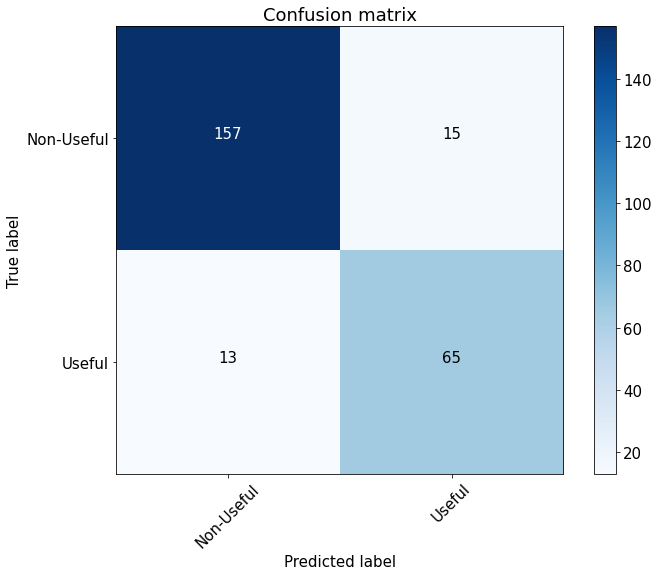

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Useful', 'Useful'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [13]:
result = X_test[['content','Useful']]
result

,content,Useful
521,Все хорошо.,0
737,👍,0
740,Хорошее предложение мне нравится удобно пользо...,0
660,"Работает чётко, ничего лишнего, со сберонлайн(...",0
411,Хорошо!,0
...,...,...
109,Мне нравится это приложение.Всем его рекомендую.,0
430,Очень крутое приложение)) Спасибо админы))),0
77,Доволен банковским обслуживанием,0
84,Все отлично,0


In [14]:
result['pred'] = [int(_>thresholds[ix]) for _ in preds]
result

<ipython-input-14-1c7f01500752>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['pred'] = [int(_>thresholds[ix]) for _ in preds]


,content,Useful,pred
521,Все хорошо.,0,0
737,👍,0,0
740,Хорошее предложение мне нравится удобно пользо...,0,0
660,"Работает чётко, ничего лишнего, со сберонлайн(...",0,0
411,Хорошо!,0,0
...,...,...,...
109,Мне нравится это приложение.Всем его рекомендую.,0,0
430,Очень крутое приложение)) Спасибо админы))),0,0
77,Доволен банковским обслуживанием,0,0
84,Все отлично,0,0


In [15]:
mask = result.Useful != result.pred
result[mask]

,content,Useful,pred
210,Почему не открывается,0,1
101,"Удобное приложение. Быстро происходит оплата, ...",1,0
277,Вожу код не открывается приложение почему? Иди...,0,1
570,Перестали загружатся расходы. Да и вообще прил...,1,0
10,Очень удобно. Оплату производишь не выходя из ...,1,0
221,Не работает чат!,0,1
66,"Мне всё нравится в приложении,ничего лишнего,р...",1,0
451,Что значит 25 на приложении,0,1
522,После ввода кода выводит на главное меню телефона,0,1
823,"Понятное, безопасное приложение. Так же радует...",1,0


## Загрузка новых отзывов и проверка на полезность отзыва

In [21]:
fieldnames = ['userName', 'content', 'score',
                  'thumbsUpCount', 'reviewCreatedVersion', 'at']
app_name = 'ru.homecredit.mycredit'

new_csv = pgp.scrape(app_name, field_names=fieldnames)
pgp.new_reviews(old_csv='homecredit_reviews.csv', new_csv=new_csv)

In [22]:
new_reviews = pd.read_csv('homecredit_reviews_update.csv', index_col=False)
new_reviews.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at
0,Sebastian Vettel,Очень удобное приложение,5,0,6.6.0,2021-07-12 15:00:58
1,SensorExcel,"Эти клоуны пишут смс что ставка 5,9 % на креди...",1,0,6.6.0,2021-07-12 14:07:47
2,Юджин Шепард,Достаточно удобно,4,0,6.6.0,2021-07-12 13:49:34
3,Яков Син,"Я незнаю, как сотрудничать с банком дистанцион...",1,0,6.6.0,2021-07-12 13:28:04
4,Артём Поляков,Какой раз не получается пополнить карту другим...,2,0,6.6.0,2021-07-12 12:40:37


In [24]:
preds = model.predict_proba(new_reviews)[:, 1]
preds[:10]

array([0.06589089, 0.73813687, 0.18167102, 0.83930707, 0.67139544,
       0.19873487, 0.56352061, 0.16787429, 0.14817929, 0.50782729])

In [27]:
new_reviews['preds'] = preds

# просмотрим полезные отзывы
mask = new_reviews.preds > 0.5
new_reviews[mask].head(3)

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,preds
1,SensorExcel,"Эти клоуны пишут смс что ставка 5,9 % на креди...",1,0,6.6.0,2021-07-12 14:07:47,0.738137
3,Яков Син,"Я незнаю, как сотрудничать с банком дистанцион...",1,0,6.6.0,2021-07-12 13:28:04,0.839307
4,Артём Поляков,Какой раз не получается пополнить карту другим...,2,0,6.6.0,2021-07-12 12:40:37,0.671395
